In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [5]:
from keras.layers import GRU

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(GRU(100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [6]:
from keras.optimizers import Adam


model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [7]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 70s 640ms/step - loss: 1.2679 - accuracy: 0.4651 - val_loss: 1.1390 - val_accuracy: 0.5337
Epoch 2/10
92/92 [==============================] - 23s 245ms/step - loss: 0.9122 - accuracy: 0.6178 - val_loss: 0.7851 - val_accuracy: 0.7192
Epoch 3/10
92/92 [==============================] - 27s 297ms/step - loss: 0.6227 - accuracy: 0.7313 - val_loss: 0.6032 - val_accuracy: 0.7974
Epoch 4/10
92/92 [==============================] - 42s 461ms/step - loss: 0.4374 - accuracy: 0.8313 - val_loss: 0.4463 - val_accuracy: 0.8491
Epoch 5/10
92/92 [==============================] - 20s 221ms/step - loss: 0.2950 - accuracy: 0.8951 - val_loss: 0.4233 - val_accuracy: 0.8668
Epoch 6/10
92/92 [==============================] - 26s 283ms/step - loss: 0.2021 - accuracy: 0.9281 - val_loss: 0.2380 - val_accuracy: 0.9218
Epoch 7/10
92/92 [==============================] - 40s 440ms/step - loss: 0.1878 - accuracy: 0.9330 - val_loss: 0.3532 - val_accuracy: 0.8634

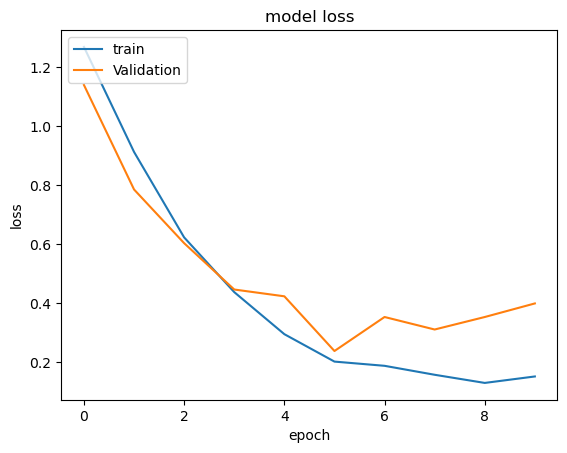

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [9]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the GRU model 0.9019341468811035
93/93 [==============================] - 4s 35ms/step


In [10]:
predictions

array([[3.6515798e-03, 5.8273745e-05, 1.0196061e-04, 5.1276474e-03,
        9.9106008e-01, 4.3305656e-07],
       [4.2507593e-03, 5.3310847e-05, 7.0489405e-05, 3.9691250e-03,
        9.9165595e-01, 3.0555711e-07],
       [3.6723209e-03, 5.2612148e-05, 8.2051163e-05, 4.6403720e-03,
        9.9155229e-01, 3.9242627e-07],
       ...,
       [4.5056529e-03, 9.9537969e-01, 1.1471651e-04, 6.4302791e-10,
        5.2669986e-08, 9.0467250e-10],
       [6.7923493e-03, 9.9316770e-01, 3.9780407e-05, 2.9763698e-09,
        2.0521396e-07, 4.3030184e-09],
       [2.3159694e-02, 9.7680646e-01, 3.3159384e-05, 5.6012541e-09,
        6.4675237e-07, 7.5820248e-09]], dtype=float32)

In [11]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[456  14  26   0   0   0]
 [  9 443  18   1   0   0]
 [  0   1 419   0   0   0]
 [ 18   0   0 409  64   0]
 [  5   0   0 106 421   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.93      0.92      0.93       496
           2       0.91      0.94      0.93       471
           3       0.90      1.00      0.95       420
           4       0.79      0.83      0.81       491
           5       0.87      0.79      0.83       532
           6       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.90      2947
weighted avg       0.90      0.90      0.90      2947



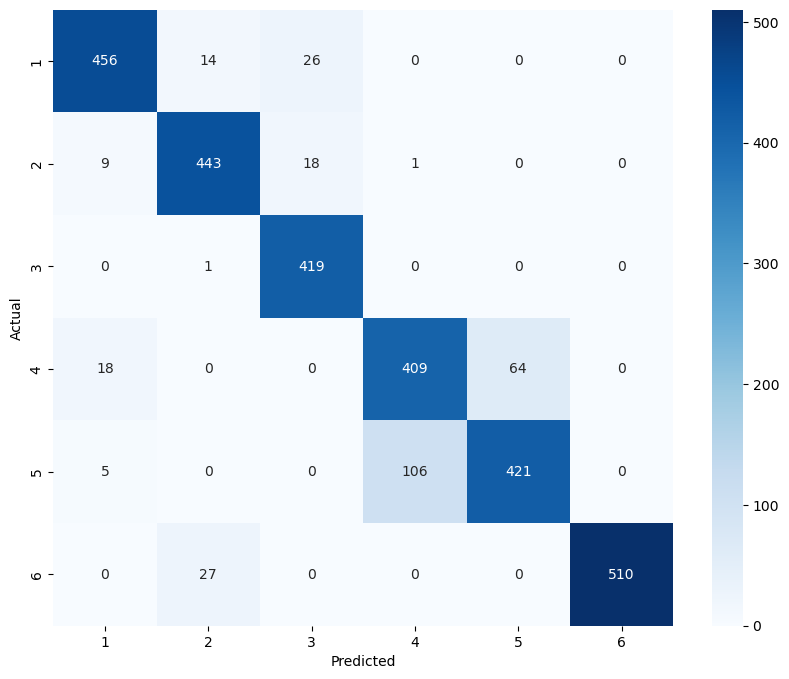

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)
